In [1]:
import glob
import os
import pandas as pd
import sklearn
import sklearn.metrics
import seaborn as sns
import matplotlib.pyplot as plt

# folder = "/Users/johnmorris/Projects/interpretable-embeddings/scripts/d3/out"
folder = 'out'
paths = glob.glob(os.path.join(folder, "d3_*.csv"))

paths[0]

'out/d3_34_bad.csv'

In [2]:
def read_csv(path):
    lines = open(path).readlines()
    lines = lines[7:]  # discard header
    all_data = []
    for line in lines:
        idx, data_str = eval(line)
        all_data.append(eval(data_str))
    return pd.DataFrame(all_data, columns=['task', 'idx', 'true_label', 'pred_label', 'answer', 'model'])


dfs = [read_csv(path) for path in paths]
df = pd.concat(dfs)

# add example_len
df['example_len'] = None
for task in df.task.unique():
    task_str = '_'.join(task.split('_')[:-1])
    examples = pd.read_csv(f'd3_processed/{task_str}.csv')
    examples['example_len'] = examples['input'].apply(lambda x: len(x.split()))
    # set example_len for each task based on "idx" column
    df.loc[df.task == task, 'example_len'] = df[df.task ==
                                                task].idx.apply(lambda x: examples.loc[x].example_len)

# add ensemble model
df['majority_vote'] = df.groupby(['task', 'idx'])['pred_label'].transform(
    lambda x: x.value_counts().idxmax())
d_ens = df[df.model == 'meta']
d_ens['model'] = 'ensemble'
d_ens['pred_label'] = d_ens['majority_vote']
df = pd.concat([df, d_ens])

df['correct'] = df['true_label'] == df['pred_label']

/tmp/ipykernel_3819151/830255380.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_ens['model'] = 'ensemble'
/tmp/ipykernel_3819151/830255380.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_ens['pred_label'] = d_ens['majority_vote']


In [3]:
df.groupby('model')['correct'].mean()
# df[df.example_len <= 100000].groupby('model')['correct'].mean()

model
ensemble    0.768950
meta        0.765487
mistral     0.763563
openai      0.737207
Name: correct, dtype: float64

,model,task,correct
0,LLaMA-3 (8B),d3_0_irony,0.58
1,LLaMA-3 (8B),d3_10_infrastructure,0.82
2,LLaMA-3 (8B),d3_12_medical,0.85
3,LLaMA-3 (8B),d3_13_water,0.87
4,LLaMA-3 (8B),d3_14_search,0.85
...,...,...,...
151,ChatGPT,d3_5_evacuate,0.83
152,ChatGPT,d3_6_terorrism,0.95
153,ChatGPT,d3_7_crime,0.83
154,ChatGPT,d3_8_shelter,0.84


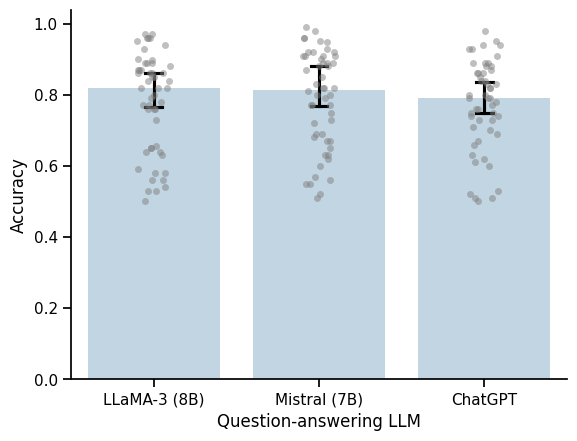

In [19]:
sns.set_context('notebook')
d_plot = df
# d_plot = df[df.example_len <= 1000]
d_plot = d_plot[~d_plot.model.isin(['ensemble'])]
d_plot = d_plot.groupby(['model', 'task'])['correct'].mean().reset_index()
d_plot['correct'] = d_plot['correct'].apply(lambda x: max(x, 1 - x))
d_plot['model'] = d_plot['model'].apply(lambda x:
                                        {'meta': 'LLaMA-3 (8B)', 'ensemble': 'Ensemble', 'mistral': 'Mistral (7B)', 'openai': 'ChatGPT'}.get(x, x))
display(d_plot)

# plot boxplot where each point is a task
sns.barplot(x='model', y='correct', data=d_plot,
            estimator='median', errorbar=('ci', 95), err_kws={'color': 'black'}, capsize=0.1, alpha=0.3)

# show points
sns.stripplot(x='model', y='correct', data=d_plot, color='gray', alpha=0.5)
sns.despine()
plt.xlabel('Question-answering LLM')
plt.ylabel('Accuracy')
plt.savefig('d3_accuracy.pdf', bbox_inches='tight')
plt.show()

In [ ]:
df.groupby(['model'])['correct'].sem()

In [ ]:
for model in df['model'].unique():
    model_df = df[df['model'] == model]
    print(model, sklearn.metrics.f1_score(
        model_df['true_label'], model_df['pred_label']))

In [ ]:
# .reset_index().pivot(index='task', columns='model', values='correct').to_latex()
d = df.groupby(['model', 'task'])['correct'].mean().reset_index()

In [ ]:
d['correct'] = d['correct'].apply(lambda x: max(x, 1 - x))

In [ ]:
d.groupby('model')['correct'].mean()

In [ ]:
# fullly display d
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(d)